### INTRODUCTION
This project gives a full data mining perspective for the Vehicle Sales Data dataset. It's main goal is to show the usage of a proper model (in this case XGboost) to predict a market price for an input car.
The UI is prepared on Streamlit to create a full demo for this project.

# Setting up the environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Plotting config
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


# LOAD DATA

In [2]:
df = pd.read_csv('/kaggle/input/vehicle-sales-data/car_prices.csv')

print(f"Dataset shape: {df.shape}")
print(df.head()) #head of dataset
print(df.dtypes) # types of values
print(df.isnull().sum()) # print null values per col


Dataset shape: (558837, 16)
   year   make                model        trim   body transmission  \
0  2015    Kia              Sorento          LX    SUV    automatic   
1  2015    Kia              Sorento          LX    SUV    automatic   
2  2014    BMW             3 Series  328i SULEV  Sedan    automatic   
3  2015  Volvo                  S60          T5  Sedan    automatic   
4  2014    BMW  6 Series Gran Coupe        650i  Sedan    automatic   

                 vin state  condition  odometer  color interior  \
0  5xyktca69fg566472    ca        5.0   16639.0  white    black   
1  5xyktca69fg561319    ca        5.0    9393.0  white    beige   
2  wba3c1c51ek116351    ca       45.0    1331.0   gray    black   
3  yv1612tb4f1310987    ca       41.0   14282.0  white    black   
4  wba6b2c57ed129731    ca       43.0    2641.0   gray    black   

                                   seller      mmr  sellingprice  \
0                 kia motors america  inc  20500.0       21500.0   
1     

# OUTLIER FILTERING

In [3]:

original_size = len(df)

# rule-based filtering
df_filtered = df[
    (df['year'] >= 1990) & (df['year'] <= 2026) & # very old cars + invalid or new entries
    (df['odometer'] > 0) & (df['odometer'] <= 500_000) & # extremely rare, may be an error
    (df['sellingprice'] > 500) & (df['sellingprice'] <= 150_000) & # scrap/ invalid sales
    (df['condition'] >= 1) & (df['condition'] <= 49) #validating condition
].copy()

# statistical outlier filtering (IQR method)
Q1 = df_filtered['sellingprice'].quantile(0.01)
Q3 = df_filtered['sellingprice'].quantile(0.99)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

# final price-based filtering
df_filtered = df_filtered[
    (df_filtered['sellingprice'] >= lower_bound) &
    (df_filtered['sellingprice'] <= upper_bound)
]

print(f"Original dataset: {original_size:,} rows")
print(f"After filtering: {len(df_filtered):,} rows")


Original dataset: 558,837 rows
After filtering: 540,161 rows


# STRATIFIED SAMPLING

In [4]:
# 20% of the filtered dataset + max 100k rows
target_size = min(100_000, int(len(df_filtered) * 0.2)) 

# car age strongly influences price
df_filtered['year_bin'] = pd.cut(df_filtered['year'], bins=10, labels=False)
df_filtered['price_bin'] = pd.qcut(df_filtered['sellingprice'], q=10, labels=False, duplicates='drop')

df_sample = df_filtered.groupby(['year_bin', 'price_bin'], group_keys=False).apply(
    lambda x: x.sample(min(len(x), max(1, int(len(x) * target_size / len(df_filtered)))), random_state=RANDOM_STATE)
).reset_index(drop=True)

df_sample = df_sample.drop(['year_bin', 'price_bin'], axis=1)

print(f"Sample size: {len(df_sample):,}")


Sample size: 99,970


# DATA CLEANING + STANDARTIZATION

In [5]:
df_sample['make'] = df_sample['make'].fillna('Unknown').astype(str).str.title().str.strip()
df_sample['model'] = df_sample['model'].fillna('Unknown').astype(str).str.title().str.strip()
df_sample['body'] = df_sample['body'].fillna('Other').apply(lambda x: x.lower().strip())
df_sample['transmission'] = df_sample['transmission'].fillna('unknown').astype(str).str.lower()

# Standardize body types
def standardize_body(body):
    if 'coupe' in body or 'cpe' in body: return 'Coupe'
    if 'sedan' in body or 'sdn' in body: return 'Sedan'
    if 'suv' in body or 'sport utility' in body: return 'SUV'
    if 'truck' in body or 'pickup' in body: return 'Truck'
    if 'van' in body or 'minivan' in body: return 'Van'
    if 'wagon' in body or 'wgn' in body: return 'Wagon'
    if 'convertible' in body or 'conv' in body or 'cabriolet' in body: return 'Convertible'
    if 'hatchback' in body or 'hatch' in body: return 'Hatchback'
    return 'Other'

df_sample['body'] = df_sample['body'].apply(standardize_body)

# fill remaining missing numeric columns
df_sample['trim'] = df_sample['trim'].fillna('Unknown')
df_sample['color'] = df_sample['color'].fillna('Unknown')
df_sample['interior'] = df_sample['interior'].fillna('Unknown')

# re-print null values per col
print(df_sample.isnull().sum())


year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
mmr             0
sellingprice    0
saledate        0
dtype: int64


# EXPLORATORY DATA ANALYSIS - EDA

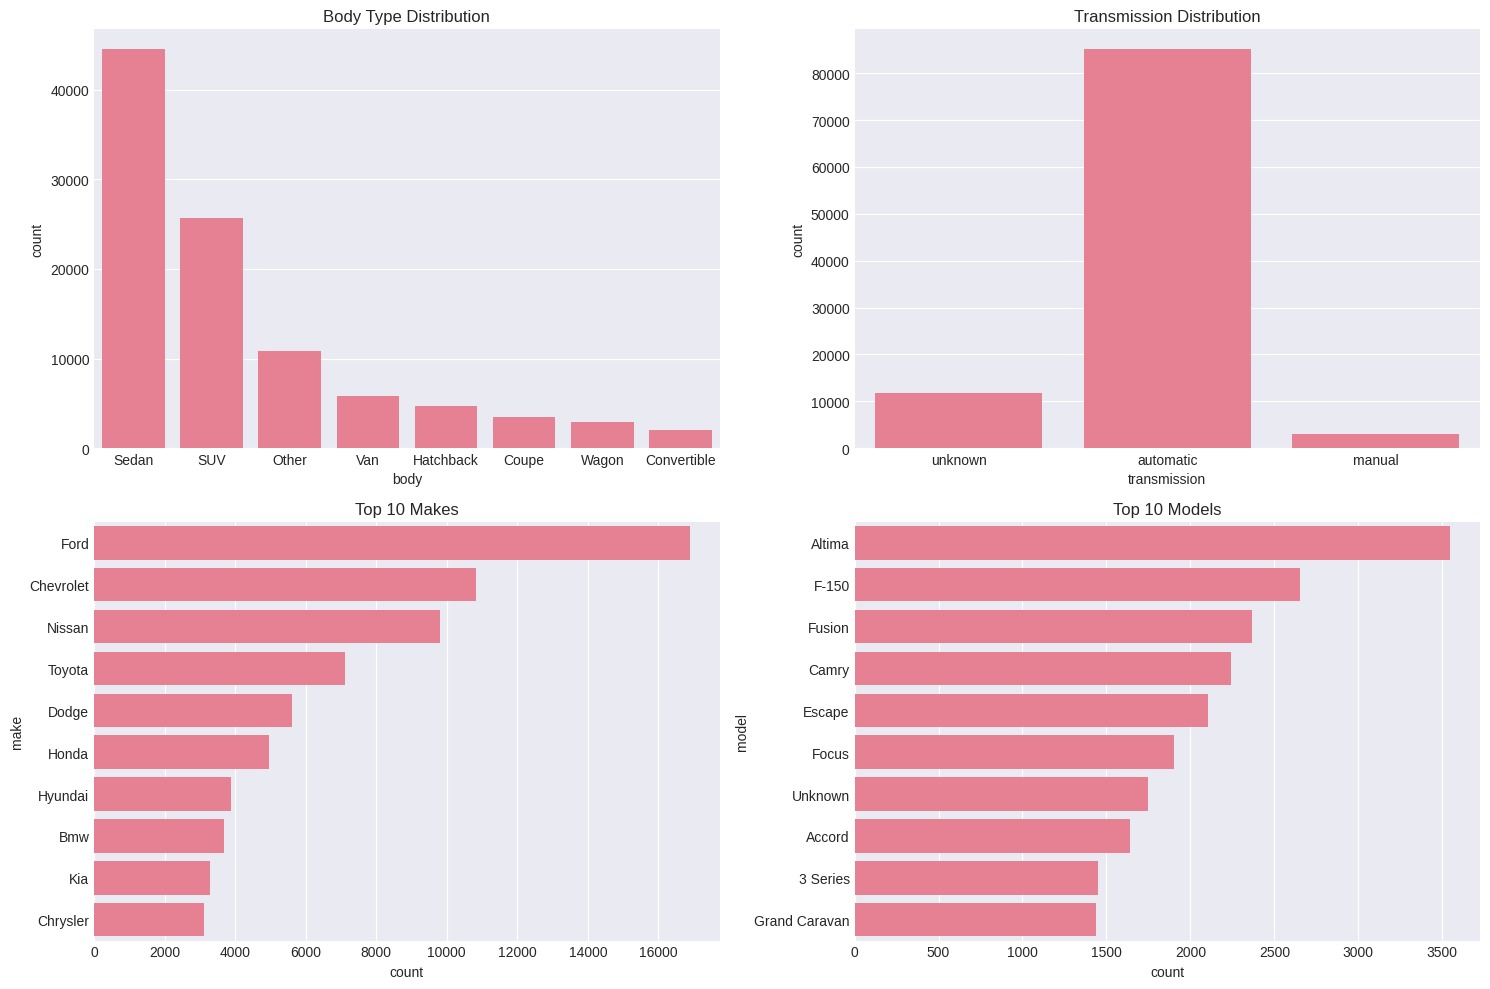

In [6]:
# visualise categorical features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.countplot(data=df_sample, x='body', order=df_sample['body'].value_counts().index, ax=axes[0,0])
axes[0,0].set_title('Body Type Distribution')
sns.countplot(data=df_sample, x='transmission', ax=axes[0,1])
axes[0,1].set_title('Transmission Distribution')
sns.countplot(data=df_sample, y='make', order=df_sample['make'].value_counts().index[:10], ax=axes[1,0])
axes[1,0].set_title('Top 10 Makes')
sns.countplot(data=df_sample, y='model', order=df_sample['model'].value_counts().index[:10], ax=axes[1,1])
axes[1,1].set_title('Top 10 Models')
plt.tight_layout()
plt.show()

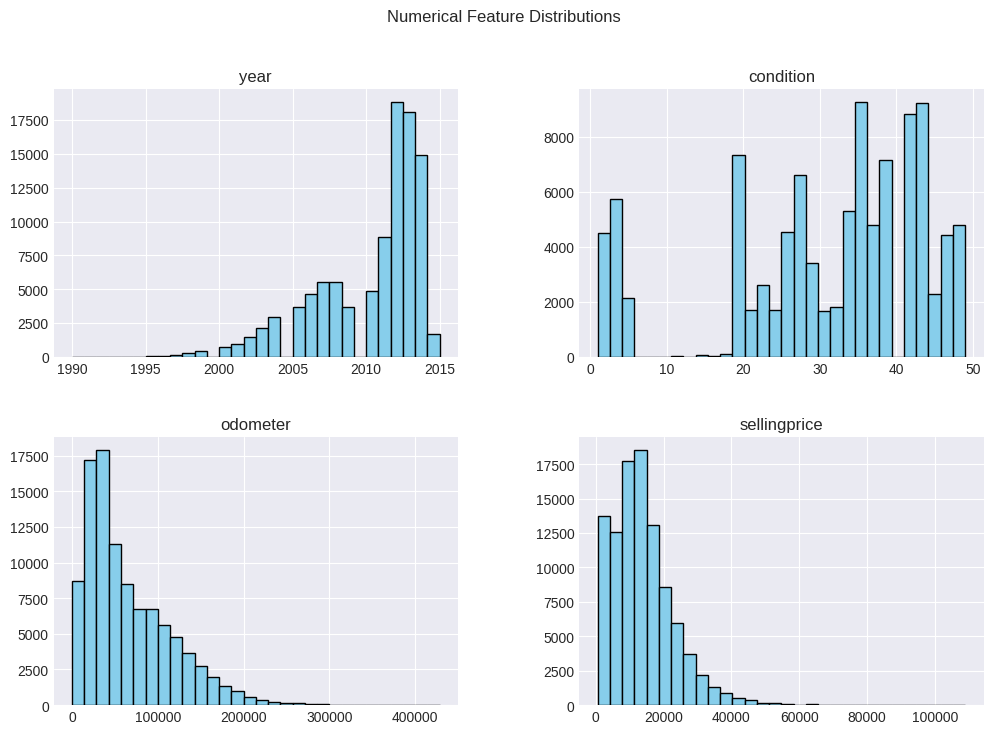

In [7]:
# numerical feature distributions
num_cols = ['year', 'condition', 'odometer', 'sellingprice']
df_sample[num_cols].hist(bins=30, figsize=(12,8), color='skyblue', edgecolor='black')
plt.suptitle('Numerical Feature Distributions')
plt.show()

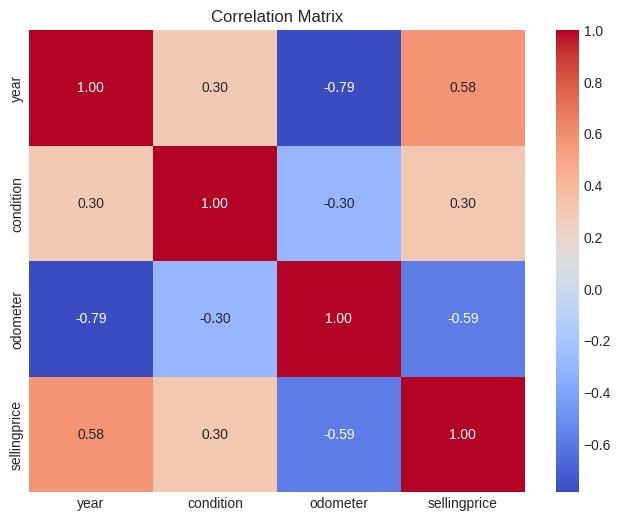

In [8]:
# correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df_sample[num_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# ENCODING CATEGORICAL FEATURES

In [9]:
categorical_cols = ['make', 'model', 'body', 'transmission']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_sample[f'{col}_encoded'] = le.fit_transform(df_sample[col])
    label_encoders[col] = le


# PREPARE FEATURES AND TARGET

In [10]:
# split- 80% for training and 20% for testing
feature_cols = ['year','condition','odometer','make_encoded','model_encoded','body_encoded','transmission_encoded']
X = df_sample[feature_cols]
y = df_sample['sellingprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")


Train: 79976, Test: 19994


# TRAINING XGBOOST MODEL

In [11]:
# declare XGBOOST parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'eval_metric': 'rmse'
}

# Create an XGBoost Regressor object
xgb_model = xgb.XGBRegressor(**params)
xgb_model.fit(X_train, y_train, verbose=False) # Train (fit) the model


# Make predictions
y_train_xgb = xgb_model.predict(X_train) # check overfitting
y_test_xgb = xgb_model.predict(X_test)  #evaluate generalization performance

# Evaluate performance
r2_xgb = r2_score(y_test, y_test_xgb) 
mae_xgb = mean_absolute_error(y_test, y_test_xgb) # Average absolute prediction error
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_test_xgb)) #Penalize large errors more strongly

print(f"XGBoost Regression Performance:")
print(f"R² Score: {r2_xgb:.4f}")
print(f"MAE: {mae_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")


XGBoost Regression Performance:
R² Score: 0.8928
MAE: 1952.31
RMSE: 3085.00


# FEATURE IMPORTANCE ANALYSIS

XGBoost Feature Importance (Contribution to Price Prediction):
             Feature  Importance (%)
                year       24.882332
        body_encoded       20.613156
            odometer       19.484610
        make_encoded       15.585064
       model_encoded        9.953867
           condition        8.427059
transmission_encoded        1.053913


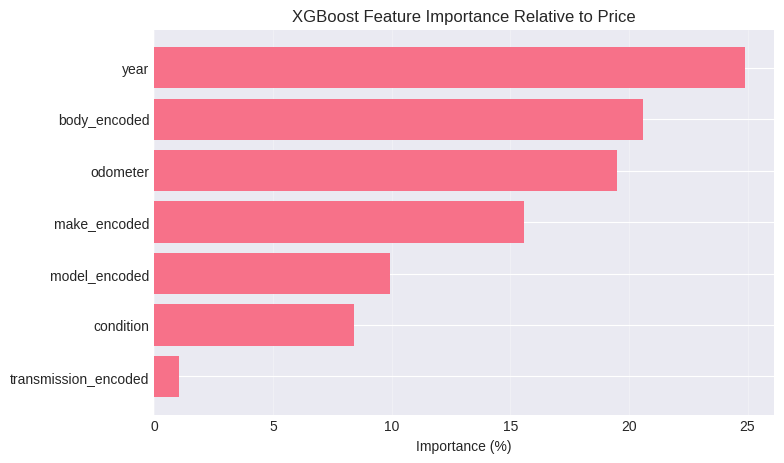

In [12]:
# Get feature importance scores (based on gain)
importance_scores = xgb_model.get_booster().get_score(importance_type='gain')

# Convert to DataFrame
importance_df = pd.DataFrame({
    'Feature': importance_scores.keys(),
    'Importance (Gain)': importance_scores.values()
})

# Normalize importance to percentages
importance_df['Importance (%)'] = (
    importance_df['Importance (Gain)'] /
    importance_df['Importance (Gain)'].sum()
) * 100

# Sort by importance
importance_df = importance_df.sort_values(by='Importance (%)', ascending=False)

# Print results
print("XGBoost Feature Importance (Contribution to Price Prediction):")
print(importance_df[['Feature', 'Importance (%)']].to_string(index=False))

#  Visualization
plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature'], importance_df['Importance (%)'])
plt.xlabel("Importance (%)")
plt.title("XGBoost Feature Importance Relative to Price")
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.show()


# SAVE MODEL AND ENCODERS FOR STREAMLIT

In [13]:
print("SAVING MODEL AND ENCODERS FOR STREAMLIT APP")

# Save the trained XGBoost model
model_filename = 'xgb_car_price_model.pkl'
joblib.dump(xgb_model, model_filename)
print(f"✓ Model saved as: {model_filename}")

# Save the label encoders dictionary
encoders_filename = 'label_encoders.pkl'
joblib.dump(label_encoders, encoders_filename)
print(f" Label encoders saved as: {encoders_filename}")

# Also save the unique values for each categorical column for the Streamlit dropdowns
categorical_values = {
    'makes': sorted(df_sample['make'].unique().tolist()),
    'models': sorted(df_sample['model'].unique().tolist()),
    'body_types': sorted(df_sample['body'].unique().tolist()),
    'transmissions': sorted(df_sample['transmission'].unique().tolist())
}

categories_filename = 'categorical_values.pkl'
joblib.dump(categorical_values, categories_filename)
print(f" Categorical values saved as: {categories_filename}")

# Save the sample dataframe for visualizations in Streamlit
sample_data_filename = 'df_sample.pkl'
joblib.dump(df_sample, sample_data_filename)
print(f" Sample data saved as: {sample_data_filename}")

# Print summary of what was saved
print("FILES CREATED:")
print(f"1. {model_filename} - XGBoost trained model")
print(f"2. {encoders_filename} - Label encoders for categorical features")
print(f"3. {categories_filename} - Unique values for dropdowns")
print(f"4. {sample_data_filename} - Sample data for visualizations")
print("\n" + "-"*70)
print("CATEGORICAL VALUES SUMMARY:")
print(f"Total Makes: {len(categorical_values['makes'])}")
print(f"Total Models: {len(categorical_values['models'])}")
print(f"Body Types: {categorical_values['body_types']}")
print(f"Transmissions: {categorical_values['transmissions']}")
print(f"Sample Data Size: {len(df_sample):,} rows")

SAVING MODEL AND ENCODERS FOR STREAMLIT APP
✓ Model saved as: xgb_car_price_model.pkl
 Label encoders saved as: label_encoders.pkl
 Categorical values saved as: categorical_values.pkl
 Sample data saved as: df_sample.pkl
FILES CREATED:
1. xgb_car_price_model.pkl - XGBoost trained model
2. label_encoders.pkl - Label encoders for categorical features
3. categorical_values.pkl - Unique values for dropdowns
4. df_sample.pkl - Sample data for visualizations

----------------------------------------------------------------------
CATEGORICAL VALUES SUMMARY:
Total Makes: 55
Total Models: 706
Body Types: ['Convertible', 'Coupe', 'Hatchback', 'Other', 'SUV', 'Sedan', 'Van', 'Wagon']
Transmissions: ['automatic', 'manual', 'unknown']
Sample Data Size: 99,970 rows
